In [1]:
# Description

# Prediction of the target variable exit_stop_id using the variables 
# datetime, route, direction, and stop_id as predictors. Because the 
# target variable is categorical with several categories and sparse, 
# only levels that appeared at least 500 times in the data were included. 
# The variable datetime denotes the date and was converted to a 3-level 
# categorical. The rest of the variables predictor variables were coded
# as integers. 

# The dataset was divided into a training set (80%) and a test set (20%).

# Algorithms: decision tree, k-NN, Random Forest, Bagging, Gradient Boosting, 
# Kernel ridge regression and Neural network.

# The parameters of the models were checked by search to optimize the 
# accuracy in the test set.
# The accuracy of the algorithms ranged from 40% (k-NN) to 63% (Bagging). 
# The neural network gave good results and further tuning can be done 
# to achieve higher accuracy.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_ridge import KernelRidge
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb

# Read both CSV files
df1 = pd.read_csv('result_20210907.csv')
df2 = pd.read_csv('result_20210911.csv')

# Concatenate the two DataFrames
data = pd.concat([df1, df2], ignore_index=True)
pd.set_option('display.max_rows', None)

# Save the result to a new CSV file
data.to_csv('combined_file.csv', index=False)

# Υπολογισμός αριθμού εγγραφών για κάθε αρχείο
num_rows_file1 = len(df1)
num_rows_file2 = len(df2)
num_rows_combined = len(data)
print(f'Αριθμός δεδομένων πριν την επεξεργασία: {num_rows_combined}')

unique_stop_id = data['stop_id'].nunique()
unique_exit_stop_ids = data['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id: {unique_stop_id}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id: {unique_exit_stop_ids}')

# Remove rows where "exit_stop_id" or "stop_id" is empty
data = data.dropna(subset=['exit_stop_id', 'stop_id'])

# Drop unnecessary columns
data_cleaned = data.drop(columns=['GarNr', 'ValidTalonaId', 'TripCompanyCode', 'stop_name', "geometry", "exit_geometry", "exit_stop_name"])

# Transform date and time to categorical variable with 3 levels (Early, Mid-day and Late)
bins = ['00:00:00', '03:00:00', '11:00:00', '17:00:00', '23:59:59']
labels = ['Late', 'Early', 'Mid-Day', 'Late']
s = pd.to_timedelta(pd.to_datetime(data_cleaned['datetime']).dt.time.astype(str))
data_cleaned['datetime'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

# Make exit_stop_id the target variable
if 'exit_stop_id' in data_cleaned.columns:
    data_copy = data_cleaned.copy()
    # Assign 'exit_stop_id' as the target variable
    y = data_copy['exit_stop_id']
    data = data_copy.drop(columns=['exit_stop_id'])

Αριθμός δεδομένων πριν την επεξεργασία: 483372
Διακριτές τιμές στη στήλη stop_id: 1601
Διακριτές τιμές στη στήλη exit_stop_id: 1569


In [3]:
# Identify targets with less that 500 ocurrences and remove them from dataset
df = pd.value_counts(y).to_frame().reset_index()
stop_id_counts = data_copy["exit_stop_id"].value_counts()
stop_ids_to_delete = stop_id_counts[stop_id_counts < 500]

# Remove the rows corresponding to the rarest values
df = data_copy[~data_copy['exit_stop_id'].isin(stop_ids_to_delete.index)]

y = df['exit_stop_id']
data = df.drop(columns=['exit_stop_id'])
print("Δεδομενα μετα τον καθαρισμο:", len(data))

unique_stop_id_updated = data['stop_id'].nunique()
unique_exit_stop_ids_updated = df['exit_stop_id'].nunique()

# Εκτύπωση των αποτελεσμάτων
print(f'Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: {unique_stop_id_updated}')
print(f'Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: {unique_exit_stop_ids_updated}')


# Convert categories to integers for classification
data["datetime"] = pd.factorize(data["datetime"])[0]
data["route"] = pd.factorize(data["route"])[0]
data["direction"] = pd.factorize(data["direction"])[0]
data["stop_id"] = pd.factorize(data["stop_id"])[0]
y = pd.factorize(y)[0]

# Create training and test subsets

x_train, x_test, y_train, y_test=train_test_split(data, y, test_size=0.20,random_state=0)


# Υπολογισμός ποσοστού για καθεμία από τις κατηγορίες στα καθαρισμένα δεδομένα
category_counts_cleaned = df['datetime'].value_counts(normalize=True) * 100

# Εκτύπωση των ποσοστών για καθεμία από τις κατηγορίες
print(f"Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):")
print(f"Late: {category_counts_cleaned.get('Late', 0):.2f}%")
print(f"Early: {category_counts_cleaned.get('Early', 0):.2f}%")
print(f"Mid-Day: {category_counts_cleaned.get('Mid-Day', 0):.2f}%")

Δεδομενα μετα τον καθαρισμο: 71640
Διακριτές τιμές στη στήλη stop_id μετα τον καθαρισμο: 1321
Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο: 72
Ποσοστό των δεδομένων ανά κατηγορία (μετά τον καθαρισμό):
Late: 14.91%
Early: 41.09%
Mid-Day: 44.01%


C:\Users\ilian\AppData\Local\Temp\ipykernel_23468\3201801570.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  df = pd.value_counts(y).to_frame().reset_index()


In [4]:
# The algorithms that are used are

## Decision tree
## k-NN
## Random Forest
## Bagging
## Gradient Boosting
## Kernel ridge regression
## Neural network

Decision Tree Results: 
    Depth  Accuracy  Cumulative Time (s)
0       1  0.084031             0.017597
1       2  0.124511             0.042320
2       3  0.154872             0.073023
3       4  0.187744             0.107084
4       5  0.210357             0.143983
5       6  0.235064             0.184716
6       7  0.267588             0.229926
7       8  0.294738             0.279336
8       9  0.312116             0.329048
9      10  0.327750             0.378433
10     11  0.346664             0.431880
11     12  0.361111             0.485768
12     13  0.374232             0.543453
13     14  0.380723             0.605988
14     15  0.386167             0.671812
15     16  0.388680             0.742803
16     17  0.393565             0.811285
17     18  0.396078             0.878447
18     19  0.395240             0.952832
19     20  0.395938             1.021921


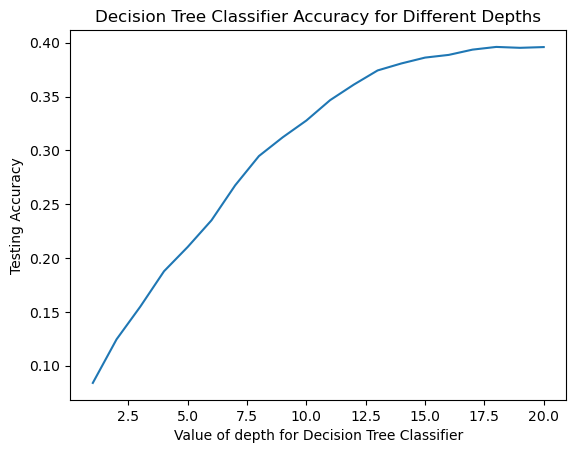

In [5]:
# Decision Tree
import time
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
times = []
total_time = 0
depths = range(1, 21)

for depth in depths:
    start_time = time.time()
    tree = DecisionTreeClassifier(max_depth=depth, random_state=2024)
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_dt = pd.DataFrame({'Depth': depths, 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Decision Tree Results: ")
print(df_dt)

plt.plot(depths, scores)
plt.xlabel('Value of depth for Decision Tree Classifier')
plt.ylabel('Testing Accuracy')
plt.title('Decision Tree Classifier Accuracy for Different Depths')
plt.show()

Bagging Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.372557             0.089518
1              2  0.378839             1.480403
2              3  0.384841             3.046257
3              4  0.387842             4.665911
4              5  0.388889             6.457464
5              6  0.388331             8.331537
6              7  0.388331             9.054825
7              8  0.389238            10.871461
8              9  0.390494            13.269278
9             10  0.390983            14.163497
10            11  0.392030            16.347503
11            12  0.393216            17.380499
12            13  0.393565            19.589908
13            14  0.395310            21.385375
14            15  0.395380            23.124526
15            16  0.394542            24.802760
16            17  0.394472            25.960111
17            18  0.394263            27.169013
18            19  0.393984            28.421178
19            20  0.39

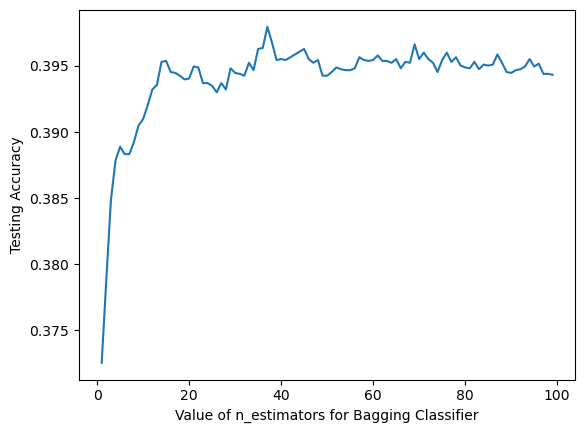

In [6]:
## Bagging for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    bagging = BaggingClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    bagging.fit(x_train, y_train)
    y_pred = bagging.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_bagging = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Bagging Results: ")
print(df_bagging)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Bagging Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

Random Forest Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.366695             0.084324
1              2  0.375279             0.199087
2              3  0.381561             0.323567
3              4  0.384213             0.466279
4              5  0.385190             0.604636
5              6  0.385678             0.746806
6              7  0.386586             0.918545
7              8  0.388540             1.088233
8              9  0.388331             1.261267
9             10  0.389308             1.464799
10            11  0.390285             1.669040
11            12  0.391541             1.885934
12            13  0.391750             2.119862
13            14  0.393774             2.369295
14            15  0.393844             2.635608
15            16  0.392448             2.918655
16            17  0.392169             3.234196
17            18  0.392030             3.561109
18            19  0.391750             3.890448
19            20

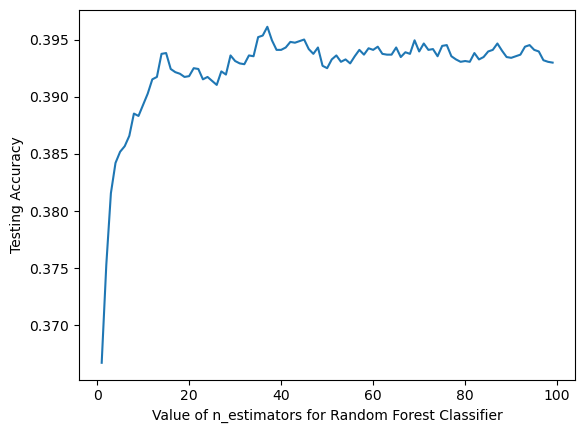

In [7]:
## Random Forest for various n_estimators

scores = []
times = []
total_time = 0
for k in range(1, 100):
    start_time = time.time()
    rfc = RandomForestClassifier(n_estimators=k, n_jobs=-1, random_state=2024)
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    times.append(total_time)  # Store cumulative time

df_rfc = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': scores, 'Cumulative Time (s)': times})
print("Random Forest Results: ")
print(df_rfc)

plt.plot(range(1, 100), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')
plt.show()

XGBoost Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.369765             0.298845
1              2  0.376884             0.465028
2              3  0.377862             0.690854
3              4  0.379048             1.069819
4              5  0.379118             1.500840
5              6  0.380793             1.993674
6              7  0.382538             2.481841
7              8  0.384562             3.196015
8              9  0.385469             4.000731
9             10  0.387493             4.897103
10            11  0.387493             5.674105
11            12  0.386446             6.589411
12            13  0.388610             7.709733
13            14  0.388959             9.060018
14            15  0.389447            10.442639
15            16  0.389308            11.691008
16            17  0.388261            12.907651
17            18  0.388680            14.192882
18            19  0.390564            15.604082
19            20  0.39

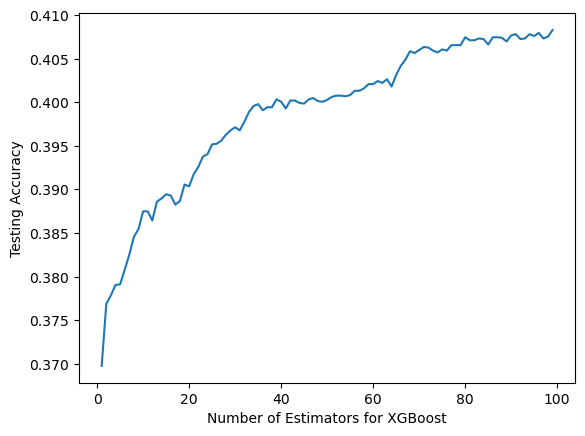

In [9]:
# XGBoost
import time
import matplotlib.pyplot as plt
%matplotlib inline
xgboost_scores = []
xgboost_times = []
total_time = 0

for n in range(1, 100):
    start_time = time.time()
    xgboost_model = xgb.XGBClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbosity=0)
    xgboost_model.fit(x_train, y_train)
    y_pred = xgboost_model.predict(x_test)
    xgboost_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    xgboost_times.append(total_time)  # Store cumulative time

df_xgboost = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': xgboost_scores, 'Cumulative Time (s)': xgboost_times})
print("XGBoost Results: ")
print(df_xgboost)

plt.plot(range(1, 100), xgboost_scores)
plt.xlabel('Number of Estimators for XGBoost')
plt.ylabel('Testing Accuracy')
plt.show()

LightGBM Results: 
    n_estimators  Accuracy  Cumulative Time (s)
0              1  0.360553             0.550713
1              2  0.371371             0.851341
2              3  0.386446             1.265053
3              4  0.387423             1.779150
4              5  0.384701             2.366903
5              6  0.379606             3.043469
6              7  0.385609             3.850719
7              8  0.385818             4.755059
8              9  0.385818             5.750454
9             10  0.386795             6.852137
10            11  0.387842             8.048182
11            12  0.390215             9.261885
12            13  0.387772            10.363822
13            14  0.387493            11.564260
14            15  0.387633            12.844449
15            16  0.388540            14.179709
16            17  0.387423            15.585686
17            18  0.386516            17.074588
18            19  0.388470            18.642005
19            20  0.3

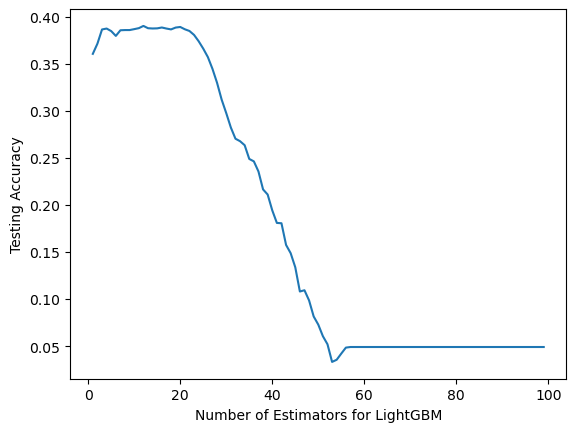

In [10]:
# LightGBM
lightgbm_scores = []
lightgbm_times = []
total_time = 0

import matplotlib.pyplot as plt
%matplotlib inline

for n in range(1, 100):
    start_time = time.time()
    lgbm_model = lgb.LGBMClassifier(n_estimators=n, learning_rate=0.1, random_state=2024, verbose=-1)
    lgbm_model.fit(x_train, y_train)
    y_pred = lgbm_model.predict(x_test)
    lightgbm_scores.append(accuracy_score(y_test, y_pred))
    total_time += time.time() - start_time  # Update total time
    lightgbm_times.append(total_time)  # Store cumulative time

df_lgbm = pd.DataFrame({'n_estimators': range(1, 100), 'Accuracy': lightgbm_scores, 'Cumulative Time (s)': lightgbm_times})
print("LightGBM Results: ")
print(df_lgbm)

plt.plot(range(1, 100), lightgbm_scores)
plt.xlabel('Number of Estimators for LightGBM')
plt.ylabel('Testing Accuracy')
plt.show()

(50148, 4) (10746, 4) (10746, 4) (50148, 72) (10746, 72) (10746, 72)
Epoch 1/65
1672/1672 [==============================] - 4s 2ms/step - loss: 3.5837 - accuracy: 0.1277 - val_loss: 3.3910 - val_accuracy: 0.1569
Epoch 2/65
1672/1672 [==============================] - 3s 2ms/step - loss: 3.2793 - accuracy: 0.1638 - val_loss: 3.1795 - val_accuracy: 0.1689
Epoch 3/65
1672/1672 [==============================] - 3s 2ms/step - loss: 3.0899 - accuracy: 0.1795 - val_loss: 3.0120 - val_accuracy: 0.1913
Epoch 4/65
1672/1672 [==============================] - 3s 2ms/step - loss: 2.9487 - accuracy: 0.1963 - val_loss: 2.8877 - val_accuracy: 0.2018
Epoch 5/65
1672/1672 [==============================] - 2s 1ms/step - loss: 2.8440 - accuracy: 0.2083 - val_loss: 2.8081 - val_accuracy: 0.2125
Epoch 6/65
1672/1672 [==============================] - 2s 1ms/step - loss: 2.7665 - accuracy: 0.2207 - val_loss: 2.7392 - val_accuracy: 0.2237
Epoch 7/65
1672/1672 [==============================] - 3s 2ms/step

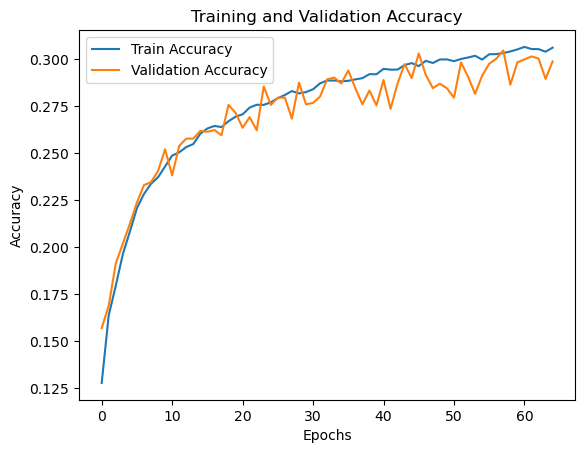

In [11]:
## Neural network 
from keras.models import Sequential
from keras.layers import Dense
from keras import backend
import numpy as np

dummy_y = to_categorical(y, num_classes=None)
scaler = StandardScaler()
data = scaler.fit_transform(data)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(data, dummy_y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

model = Sequential([
    Dense(64, activation='relu', input_shape=(4,), kernel_initializer="normal"),
    Dense(64, activation='relu', kernel_initializer="normal"),
    Dense(unique_exit_stop_ids_updated, activation='softmax', kernel_initializer="normal"),  # εξοδος το unique_exit_stop_ids_updated (δηλ οι Διακριτές τιμές στη στήλη exit_stop_id μετα τον καθαρισμο)
])


# Create the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=30, epochs=65,
          validation_data=(X_val, Y_val))

model.evaluate(X_test, Y_test)[1]

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

# Plot the accuracy
plot_accuracy(hist)